In [1]:
import joblib
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score, classification_report
from sklearn.utils import class_weight

2024-10-17 10:28:58.288857: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
xy_train = joblib.load('./data/xy/xy_train.joblib')

In [3]:
xy_train.keys()

dict_keys(['2011_2014', '2011_2015', '2011_2016', '2011_2017', '2011_2018', '2011_2019', '2011_2020', '2011_2021', '2011_2022', '2011_2023'])

In [4]:
xy_test = joblib.load('./data/xy/xy_test.joblib')

In [61]:
# Get train data
data = xy_train['2011_2023']
# Separate features and target
x = data.drop(columns=['y'])
y = data['y']

In [62]:
# Get test data
data_test = xy_test["2011_2023"]
# Separate features and target
x_test = data_test.drop(columns=['y'])
y_test = data_test['y']

In [63]:
x.shape

(821894, 166)

In [159]:
def get_model():

    model = Sequential()

    model.add(Input(shape=(x.shape[1],)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    return model

In [160]:
EPOCHS = 20
BATCH_SIZE = 10000

- Baseline model

In [161]:
model = get_model()

In [162]:
model.fit(
        x,
        y,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        verbose=1
)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc_19: 0.4910 - loss: 0.3898 - val_auc_19: 0.5135 - val_loss: 0.0360
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc_19: 0.5725 - loss: 0.0282 - val_auc_19: 0.5252 - val_loss: 0.0299
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc_19: 0.6165 - loss: 0.0260 - val_auc_19: 0.5410 - val_loss: 0.0295
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - auc_19: 0.6443 - loss: 0.0255 - val_auc_19: 0.5511 - val_loss: 0.0293
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc_19: 0.6578 - loss: 0.0254 - val_auc_19: 0.5591 - val_loss: 0.0292
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc_19: 0.6618 - loss: 0.0238 - val_auc_19: 0.5653 - val_loss: 0.0291
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc_19: 0.6872 - loss: 0.0237 - val_auc_19: 0.5727 - val_loss: 0.0291
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc_19: 0.6884 - loss: 0.0243 - val_auc_19: 0.5733 - val_loss: 0.0290
Epoch 9/20
66/66

In [163]:
y_pred = model.predict(x_test)

2248/2248 ━━━━━━━━━━━━━━━━━━━━ 2s 698us/step


In [164]:
max(y_pred), min(y_pred)

(array([0.14740434], dtype=float32), array([1.046495e-07], dtype=float32))

Text(0.5, 1.0, 'Distribuicao Scores - Classe 0 vs Classe 1')

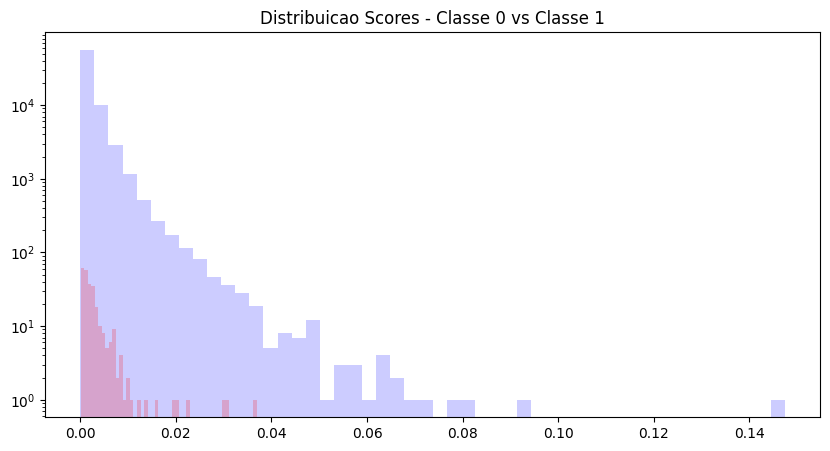

In [165]:
fix, ax = plt.subplots(figsize=(10, 5))
_=plt.hist(y_pred[y_test==0], color="b", alpha=0.2, bins=50, log=True)
_=plt.hist(y_pred[y_test==1], color="r", alpha=0.2, bins=50, log=True)
ax.set_title("Distribuicao Scores - Classe 0 vs Classe 1")

In [166]:
threshold = 0.001

In [167]:
print(classification_report(y_test, np.where(y_pred>=threshold, 1, 0)))

              precision    recall  f1-score   support

           0       1.00      0.44      0.61     71660
           1       0.00      0.72      0.01       265

    accuracy                           0.44     71925
   macro avg       0.50      0.58      0.31     71925
weighted avg       0.99      0.44      0.61     71925



In [168]:
print(f"PR-AUC: {average_precision_score(y_test, y_pred)}")

PR-AUC: 0.005254935458222385


- Using class weights

In [169]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)

In [170]:
class_weights_dict = {k:v for k, v in zip([0, 1], class_weights)}
class_weights_dict

{0: 0.5020064524089034, 1: 125.09802130898021}

In [171]:
model = get_model()

In [172]:
model.fit(
        x,
        y,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        verbose=1,
        class_weight=class_weights_dict
)

/Users/lucasdeangelisoliveira/Documents/master/1o semestre/prob e estat/env_short_squeeze/lib/python3.12/site-packages/keras/src/trainers/data_adapters/data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - auc_20: 0.6249 - loss: 0.6582 - val_auc_20: 0.6115 - val_loss: 0.6030
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc_20: 0.7495 - loss: 0.5787 - val_auc_20: 0.6609 - val_loss: 0.5367
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc_20: 0.7928 - loss: 0.5549 - val_auc_20: 0.6777 - val_loss: 0.5601
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc_20: 0.8162 - loss: 0.5211 - val_auc_20: 0.6834 - val_loss: 0.5214
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc_20: 0.8260 - loss: 0.5103 - val_auc_20: 0.6784 - val_loss: 0.4753
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc_20: 0.8463 - loss: 0.4848 - val_auc_20: 0.6819 - val_loss: 0.5245
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - auc_20: 0.8590 - loss: 0.4675 - val_auc_20: 0.6778 - val_loss: 0.5058
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - auc_20: 0.8636 - loss: 0.4608 - val_auc_20: 0.6725 - val_loss: 0.4487
Epoch 9/20
66/66

In [173]:
y_pred = model.predict(x_test)

2248/2248 ━━━━━━━━━━━━━━━━━━━━ 2s 708us/step


Text(0.5, 1.0, 'Distribuicao Scores - Classe 0 vs Classe 1')

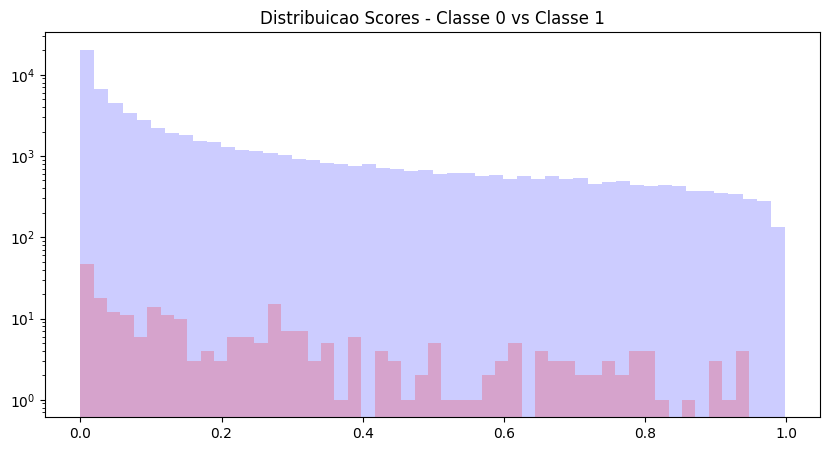

In [174]:
fix, ax = plt.subplots(figsize=(10, 5))
_=plt.hist(y_pred[y_test==0], color="b", alpha=0.2, bins=50, log=True)
_=plt.hist(y_pred[y_test==1], color="r", alpha=0.2, bins=50, log=True)
ax.set_title("Distribuicao Scores - Classe 0 vs Classe 1")

In [184]:
threshold = 0.001

In [185]:
print(classification_report(y_test, np.where(y_pred>=threshold, 1, 0)))

              precision    recall  f1-score   support

           0       1.00      0.07      0.13     71660
           1       0.00      0.99      0.01       265

    accuracy                           0.07     71925
   macro avg       0.50      0.53      0.07     71925
weighted avg       1.00      0.07      0.13     71925



In [186]:
print(f"PR-AUC: {average_precision_score(y_test, y_pred)}")

PR-AUC: 0.00456734412596931
